In [1]:
import pandas as pd

df1_exp = pd.read_csv('../data/raw/L1000_exper_affinity.csv', sep=',')
df1_exp = df1_exp[['Target ID', 'binding_affinity', 'rank', 'binding_affinity_ratio']]
df1_exp

df2_exp = pd.read_csv('../data/raw/L3000_exper_affinity.csv', sep=',')
df2_exp = df2_exp[['Target ID', 'binding_affinity', 'rank', 'binding_affinity_ratio']]
df2_exp

df_exp = pd.concat([df1_exp, df2_exp], axis=0, ignore_index=True, sort=False)
df_exp.columns = ['id', 'binding_affinity', 'rank', 'binding_affinity_ratio']

df_pred_v1 = pd.read_csv('../results/boltz_results_v1_affinity_summary.tsv', sep='\t')
df_pred_v2 = pd.read_csv('../results/boltz_results_v2_affinity_summary.tsv', sep='\t')
df_v1 = df_pred_v1.merge(df_exp, on='id')
df_v2 = df_pred_v2.merge(df_exp, on='id')


--- df_v1 correlations ---
Pearson r = -0.4998 (p = 3.232e-10)
Spearman ρ = -0.4962 (p = 4.553e-10)

--- df_v2 correlations ---
Pearson r = -0.1699 (p = 0.04476)
Spearman ρ = -0.1289 (p = 0.1289)

--- df_v1 ROC summary ---
Median(binding_affinity) = -9.886019374951358
Label counts: {1: 70, 0: 70}
AUC = 0.7320

--- df_v2 ROC summary ---
Median(binding_affinity) = -9.886019374951358
Label counts: {1: 70, 0: 70}
AUC = 0.5357



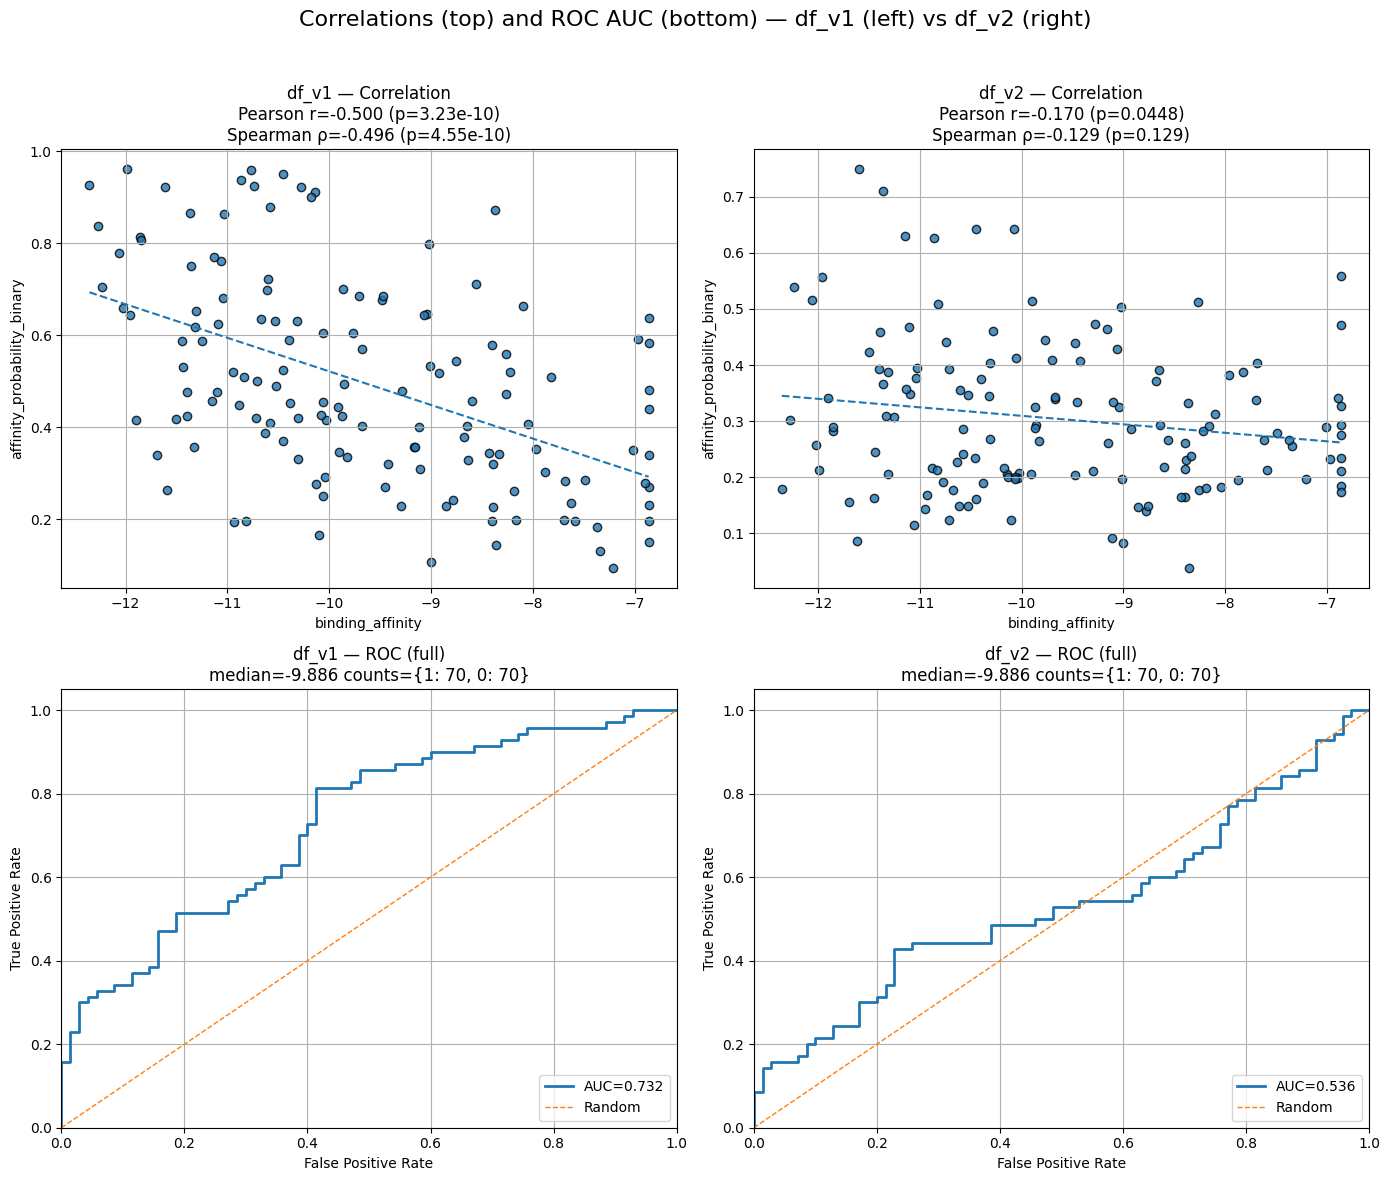

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

def compute_correlations(df, x_col='binding_affinity', y_col='affinity_probability_binary'):
    # safe numeric conversion and drop NA pairs
    x = pd.to_numeric(df[x_col], errors='coerce')
    y = pd.to_numeric(df[y_col], errors='coerce')
    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]
    if len(x) < 2:
        return {'pearson_r': np.nan, 'pearson_p': None, 'spearman_r': np.nan, 'spearman_p': None}
    # try scipy for p-values
    try:
        from scipy import stats
        pr, pp = stats.pearsonr(x, y)
        sr, sp = stats.spearmanr(x, y)
    except Exception:
        pr = x.corr(y, method='pearson')
        pp = None
        sr = x.corr(y, method='spearman')
        sp = None
    return {'pearson_r': pr, 'pearson_p': pp, 'spearman_r': sr, 'spearman_p': sp}

def compute_roc(df, score_col='affinity_probability_binary', affinity_col='binding_affinity', method='median'):
    d = {}
    dfc = df.copy()
    # create binary labels by median split (label=1 if affinity < median)
    if method == 'median':
        median_val = dfc[affinity_col].median()
        d['median'] = median_val
        dfc['label'] = (dfc[affinity_col] < median_val).astype(int)
    else:
        raise ValueError("Only 'median' method supported in this helper")
    d['label_counts'] = dfc['label'].value_counts().to_dict()
    if dfc['label'].nunique() < 2:
        d['ok'] = False
        d['reason'] = 'Only one class present after median split'
        return d
    y_true = dfc['label'].values
    y_score = pd.to_numeric(dfc[score_col], errors='coerce').fillna(0).values
    try:
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        roc_auc_val = roc_auc_score(y_true, y_score)
        d.update({'ok': True, 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': roc_auc_val})
    except Exception as e:
        d['ok'] = False
        d['reason'] = f'Error computing ROC: {e}'
    return d

def summarize_and_plot(df1, df2,
                       x_col='binding_affinity', y_col='affinity_probability_binary',
                       save_path=None):
    # compute numbers
    corr1 = compute_correlations(df1, x_col, y_col)
    corr2 = compute_correlations(df2, x_col, y_col)
    roc1 = compute_roc(df1, y_col, x_col, method='median')  # note: args are (df, score_col, affinity_col)
    roc2 = compute_roc(df2, y_col, x_col, method='median')

    # Print numeric summaries
    def print_corr(name, corr):
        print(f"--- {name} correlations ---")
        print(f"Pearson r = {corr['pearson_r']:.4f}" if pd.notna(corr['pearson_r']) else "Pearson r = nan",
              f"(p = {corr['pearson_p']:.4g})" if corr['pearson_p'] is not None else "(p = N/A)")
        print(f"Spearman ρ = {corr['spearman_r']:.4f}" if pd.notna(corr['spearman_r']) else "Spearman ρ = nan",
              f"(p = {corr['spearman_p']:.4g})" if corr['spearman_p'] is not None else "(p = N/A)")
        print()
    print_corr('df_v1', corr1)
    print_corr('df_v2', corr2)

    def print_roc(name, res):
        print(f"--- {name} ROC summary ---")
        if not res.get('ok', False):
            print("ROC not available:", res.get('reason', ''))
        else:
            print(f"Median(binding_affinity) = {res['median']}")
            print("Label counts:", res['label_counts'])
            print(f"AUC = {res['auc']:.4f}")
        print()
    print_roc('df_v1', roc1)
    print_roc('df_v2', roc2)

    # Plotting 2x2: top row correlations (scatter+fit), bottom row ROC curves
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Helper plot for scatter + linear fit
    def plot_scatter(ax, df, corr, title):
        x = pd.to_numeric(df[x_col], errors='coerce')
        y = pd.to_numeric(df[y_col], errors='coerce')
        mask = ~(x.isna() | y.isna())
        x = x[mask].values
        y = y[mask].values
        ax.scatter(x, y, alpha=0.8, edgecolor='k')
        if len(x) >= 2 and np.isfinite(x).all() and np.isfinite(y).all():
            m, b = np.polyfit(x, y, 1)
            xs = np.linspace(np.min(x), np.max(x), 200)
            ax.plot(xs, m*xs + b, linestyle='--', linewidth=1.5)
        # Title with stats
        title_stats = f"{title}\nPearson r={corr['pearson_r']:.3f}"
        if corr['pearson_p'] is not None:
            title_stats += f" (p={corr['pearson_p']:.3g})"
        title_stats += f"\nSpearman ρ={corr['spearman_r']:.3f}"
        if corr['spearman_p'] is not None:
            title_stats += f" (p={corr['spearman_p']:.3g})"
        ax.set_title(title_stats)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.grid(True)

    # Helper plot for ROC
    def plot_roc(ax, res, title, zoom=False):
        if not res.get('ok', False):
            ax.text(0.5, 0.5, f"ROC not available\n{res.get('reason','')}", ha='center', va='center')
            ax.set_title(title + " (no ROC)")
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.grid(True)
            return
        fpr, tpr = res['fpr'], res['tpr']
        ax.plot(fpr, tpr, lw=2, label=f'AUC={res["auc"]:.3f}')
        ax.plot([0,1], [0,1], linestyle='--', lw=1, label='Random')
        if zoom:
            ax.set_xlim(0.0, 0.2)
        else:
            ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 1.05)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f"{title}\nmedian={res.get('median',np.nan):.4g} counts={res.get('label_counts',{})}")
        ax.legend(loc='lower right')
        ax.grid(True)

    # Top-left: correlations df_v1
    plot_scatter(axes[0,0], df1, corr1, 'df_v1 — Correlation')

    # Top-right: correlations df_v2
    plot_scatter(axes[0,1], df2, corr2, 'df_v2 — Correlation')

    # Bottom-left: ROC df_v1 (full)
    plot_roc(axes[1,0], roc1, 'df_v1 — ROC (full)', zoom=False)

    # Bottom-right: ROC df_v2 (full)
    plot_roc(axes[1,1], roc2, 'df_v2 — ROC (full)', zoom=False)

    plt.suptitle('Correlations (top) and ROC AUC (bottom) — df_v1 (left) vs df_v2 (right)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        fig.savefig(save_path, dpi=200)
        print(f"Saved figure to: {save_path}")

    plt.show()

# === Run the summary & plot function ===
# expects df_v1 and df_v2 to exist in the namespace
summarize_and_plot(df_v1, df_v2, save_path=None)
